# Sourcetracker2

In [1]:
import pandas as pd
from utils.utils import  save_fna

#Qiime
import qiime2 as q2
from qiime2.plugins.feature_table.actions import rarefy
from biom import Table, load_table
import biom
from biom.util import biom_open

from scipy.stats import sem

# Import and format data

Import

In [2]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"

#Import bioms
stody_bt = load_table(root_dir + "intermediate_data/20200611_filtered_16S_table.biom")
rhee_bt = load_table(root_dir + "raw_data/59593_reference-hit.biom")
vaginal_bt = load_table(root_dir + "raw_data/data_10894/10894_vaginal.biom")

#Import metadata
stody_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)
md_v = pd.read_csv(root_dir + "raw_data/data_10894/10894_md.txt", sep='\t', index_col=0)
md_rhee = pd.read_csv(root_dir + "metadata/20201106_rhee_filtered_metadata.tsv", sep='\t', dtype={"sample_name":str})
md_rhee = md_rhee.set_index("sample_name")

stody_md.index.name = "sample_name"
md_rhee.index.name = "sample_name"
md_v.index.name= "sample_name"

Filter by sampels in data and metadata

In [5]:
#Filter Rhee data and metadata
md_samples = set(md_rhee.index)
bt_samples = set (rhee_bt.ids() )
all_samples_keep = bt_samples & md_samples
md_rhee = md_rhee.query('index in @all_samples_keep')
rhee_bt.filter(all_samples_keep)

#Filter vaginal data and metadata
md_samples = set(md_v.index)
bt_samples = set (vaginal_bt.ids() )
all_samples_keep = bt_samples & md_samples
md_v = md_v.query('index in @all_samples_keep')
vaginal_bt.filter(all_samples_keep)

171904 x 427 <class 'biom.table.Table'> with 41987 nonzero entries (0% dense)

Trim to 100

In [4]:
#Trim from 150bp to 100bp deblur
def trim_to_100(bt):
    shorten_dict = {asv:{"asv_100":asv[:100]} for asv in bt.ids("observation")}
    bt.add_metadata(shorten_dict, axis="observation")
    bin_f = lambda id_, x: x['asv_100']
    out_bt = bt.collapse(bin_f, norm=False, axis="observation")
    return(out_bt)
rhee_bt = trim_to_100(rhee_bt)
stody_bt = trim_to_100(stody_bt)

Filter samples < 500 and features < 10

In [6]:
rhee_bt.filter(rhee_bt.ids("sample")[rhee_bt.sum("sample") > 500], axis="sample")
rhee_bt.filter(rhee_bt.ids("observation")[rhee_bt.sum("observation") > 9], axis="observation")

#Filter vaginal samples < 10
vaginal_bt.filter(vaginal_bt.ids("observation")[vaginal_bt.sum("observation") > 9], axis="observation")


1546 x 427 <class 'biom.table.Table'> with 38254 nonzero entries (5% dense)

Import age study data

In [6]:
shi_dir="/projects/cmi_proj/tutorials/public_human_reference_data/age_prediction_input/"
gut_bt =load_table(shi_dir + "/gut_data/gut_4434_unrarified.biom")
oral_bt =load_table(shi_dir + "/oral_data/oral_2550.biom")
skin_bt = load_table(shi_dir + "/skin_data/skin_1975.biom")

gut_bt.filter(gut_bt.ids("observation")[gut_bt.sum("observation") > 9], axis="observation")
oral_bt.filter(oral_bt.ids("observation")[oral_bt.sum("observation") > 9], axis="observation")
skin_bt.filter(skin_bt.ids("observation")[skin_bt.sum("observation") > 9], axis="observation")


shi_stool_md = pd.read_csv(shi_dir + "gut_data/gut_4434_map.txt", sep='\t', index_col=0)
shi_oral_md = pd.read_csv(shi_dir + "oral_data/oral_2550_map.txt", sep='\t', index_col=0)
shi_skin_md = pd.read_csv(shi_dir + "skin_data/skin_1975_map.txt", sep='\t', index_col=0)

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (87,280,391,626,660,661,760,761,763,764,765,766,767,768,769,806,809,933) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (124,384,841,844,968) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Format and merge metadata

In [7]:
#shi_short_columns = ["age","sex","race","country","age_groups","qiita_study_id", "sample_type", "host_subject_id", "Env"]
md_cols = ["age_years","age_days","sex","race","country","age_groups","qiita_study_id", "dataset","metadata_abx","sample_type", "delivery_mode","host_subject_id", "Env","SourceSink"]

#############
##SHI data###
#############
#Format oral
shi_oral_md["sample_type"] = "Oral"
shi_oral_md["Env"] = "adult_oral"
#Format Skin
shi_skin_md["sample_type"] = "Skin"
shi_skin_md["Env"] = "adult_skin"
#Format stool
shi_stool_md.rename(columns= {"age_group":"age_groups"}, inplace=True)
shi_stool_md["sample_type"] = "Stool"
shi_stool_md["Env"] = "adult_stool"
#Merge shi metadata
shi_merged_metadata = shi_oral_md.append(shi_skin_md).append(shi_stool_md)
shi_merged_metadata["SourceSink"] = "source"
shi_merged_metadata["qiita_study_id"] = shi_merged_metadata.X_sample_id.apply(lambda x: x.split('.')[0])
shi_merged_metadata["abx_any_source"] = 0
shi_merged_metadata["age_years"] = shi_merged_metadata.age
shi_merged_metadata["age_days"] = [x*365 for x in shi_merged_metadata.age]
shi_merged_metadata["dataset"] = "Shi"
shi_merged_metadata = shi_merged_metadata.loc[:,md_cols]

#############
##Vaginal###
#############
md_v["SourceSink"] = "source"
md_v["Env"] = "vaginal"
md_v["abx_any_source"] = 0
md_v["age_years"] = "not provided"
md_v["age_days"] = "not provided"
md_v["dataset"] = "vaginal"
md_v_short = md_v.loc[:,md_cols]

#############
##Rhee data###
#############
md_rhee["SourceSink"] = "source"
md_rhee["Env"] = "FT_infant_stool"
md_rhee["age_days"] = md_rhee["age"]
md_rhee["age_years"] = [x/365 for x in md_rhee.age]
md_rhee["dataset"] = "Rhee"
md_rhee_short = md_rhee.loc[:,md_cols]

#############
##Stody data###
#############
stody_md["age_days"] = [int(x) for x in stody_md.age]
stody_md["age_years"] = 0
stody_md["SourceSink"] = "sink"
stody_md["Env"] = "sink"
stody_md["dataset"] = "Stody"
stody_md_short = stody_md.loc[:,md_cols]

all_md_merged = pd.concat([shi_merged_metadata,md_v_short,md_rhee_short,stody_md_short])
all_md_merged.index.name="sample_name"
out_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/"
#all_md_merged.to_csv(out_dir + "sourcetracker_md.tsv",sep='\t')


In [29]:
out_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/"

all_md_merged = pd.read_csv(out_dir + "sourcetracker_md.tsv",sep='\t')

In [41]:
keep=[name for name,x in all_md_merged.qiita_study_id.value_counts().items() if x > 1]
all_md_merged.query('qiita_study_id in @keep').groupby("qiita_study_id").sample_type.value_counts()

qiita_study_id  sample_type  
10052           Oral               16
10317           Stool            2825
                Oral              547
                Skin              440
10894           vaginal mucus     427
10918           Stool              96
11052           Oral              178
                Skin              177
11712           Skin              252
                Oral              243
                Stool             220
11713           Skin              102
                Oral               87
                Stool              85
1774            Oral               48
1841            Skin             1293
                Oral              642
2010            Oral               72
                Skin               65
2024            Oral              254
2202            Oral              285
550             Oral              508
Name: sample_type, dtype: int64

Merge biom tables and save qza

In [8]:
all_merged_bt = gut_bt.merge(oral_bt).merge(skin_bt).merge(stody_bt).merge(rhee_bt).merge(vaginal_bt)
#Filter out samples with < 500 hits
all_merged_bt.filter(all_merged_bt.ids()[all_merged_bt.sum("sample") > 500])


#Remove metadata
all_merged_bt.del_metadata(axis="observation")

#Save biom
out_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/"
def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)
save_biom(out_dir + "20200608_sourcetracer_data.biom", all_merged_bt)

#Convert to qza
all_merged_qza = q2.Artifact.import_data('FeatureTable[Frequency]', all_merged_bt)

#Save qza

all_merged_qza.save(out_dir + "20200608_sourcetracer_data.qza")

Saved to /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/20200608_sourcetracer_data.biom


'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/20200608_sourcetracer_data.qza'

# Make merged data for Empress with Stody and shi

In [19]:
#Make merged biom table from Stody and Shi
empress_bt = gut_bt.merge(oral_bt).merge(skin_bt).merge(stody_bt)
empress_bt.del_metadata(axis="observation")


In [20]:



#Make merged metadata
empress_md = pd.concat([shi_merged_metadata,stody_md_short])
empress_md.index.name = "sample_name"

def make_study_delivery_mode(row):
    if row.qiita_study_id==11712:
        study="LPI"
    elif row.qiita_study_id==11713:
        study="VLBW"
    else:
        return("adult")
    del_mode=row.delivery_mode
    if row.metadata_abx==1:
        abx="abx+"
    else:
        abx="abx-"
    return("{}_{}_{}".format(study, del_mode, abx))

empress_md["major_group"] = empress_md.apply(axis=1, func=make_study_delivery_mode)
empress_md["adult_infant"] = empress_md.apply(axis=1, func=lambda row:"infant" if row.dataset=="Stody" else "adult")

#Save metadata
empress_md.to_csv(root_dir + "intermediate_data/empress_data/20200617_stody_shi_metadata_for_empress.tsv", sep='\t')

#Save biom table
def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)
save_biom(root_dir + "intermediate_data/empress_data/20201617_stody_shi_table_for_empress.biom", empress_bt)
#

#Export sequences
#Save fna and qza of all sequences from all samples in stody and shi
seq_out="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/empress_data/20200617_stody_shi_empress_seqs"
save_fna(bt=empress_bt, out_root=seq_out)


Saved to /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/empress_data/20201617_stody_shi_table_for_empress.biom


0

In [32]:
bt = load_table(root_dir + "intermediate_data/empress_data/20201617_stody_shi_table_for_empress.biom")
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
qza.save(root_dir + "intermediate_data/empress_data/20201617_stody_shi_table_for_empress.qza")

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/empress_data/20201617_stody_shi_table_for_empress.qza'

In [40]:
empress_md.metadata_abx.value_counts()

0.0    633
1.0    536
Name: metadata_abx, dtype: int64

In [34]:
empress_md

,sample_name,age_years,age_days,sex,race,country,age_groups,qiita_study_id,dataset,metadata_abx,sample_type,delivery_mode,host_subject_id,Env,SourceSink,major_group,adult_infant
0,11052.3.20.13.rk.t,36.00,13140.0,male,NaN,NaN,30s,11052,Shi,NaN,Oral,NaN,M03,adult_oral,source,adult,adult
1,10317.000003639,NaN,NaN,female,Caucasian,USA,50s,10317,Shi,NaN,Oral,NaN,c9e234a8b8023dc52f81b36210303deb253ee13dabc602...,adult_oral,source,adult,adult
2,550.L6S136.s.6.sequence,32.54,11877.1,male,NaN,GAZ:United States of America,30s,550,Shi,NaN,Oral,NaN,M3,adult_oral,source,adult,adult
3,10317.000031067,NaN,NaN,male,Caucasian,Canada,40s,10317,Shi,NaN,Oral,NaN,7335b37622ba1bdd7e488bc6758f7c8fd36c26e43d8fdb...,adult_oral,source,adult,adult
4,11052.3.28.14.rk.t,37.00,13505.0,male,NaN,NaN,30s,11052,Shi,NaN,Oral,NaN,M03,adult_oral,source,adult,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10123,11713.8.S.8C,0.00,3.0,Female,NaN,NaN,NaN,11713,Stody,1.0,Skin,c-section,11713-8,sink,sink,VLBW_c-section_abx+,infant
10124,11713.8.S.8D,0.00,4.0,Female,NaN,NaN,NaN,11713,Stody,1.0,Skin,c-section,11713-8,sink,sink,VLBW_c-section_abx+,infant
10125,11713.8.S.8E,0.00,5.0,Female,NaN,NaN,NaN,11713,Stody,1.0,Skin,c-section,11713-8,sink,sink,VLBW_c-section_abx+,infant
10126,11713.8.S.8F,0.00,6.0,Female,NaN,NaN,NaN,11713,Stody,1.0,Skin,c-section,11713-8,sink,sink,VLBW_c-section_abx+,infant


Make Phylogeny for Empress

In [21]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /home/swandro/infant/logs
#PBS -o /home/swandro/infant/logs
#PBS -l walltime=48:00:00
#PBS -l nodes=1:ppn=16
#PBS -l mem=160gb
#PBS -N sepp_stody

source ~/.bash_profile
conda activate qiime2-2020.2

data_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/empress_data

qiime fragment-insertion sepp \
  --i-representative-sequences $data_dir/20200617_stody_shi_empress_seqs.qza \
  --i-reference-database /home/swandro/databases/sepp-refs-gg-13-8.qza \
  --o-tree $data_dir/20200617_stody_shi_empress_insertion_tree.qza \
  --o-placements $data_dir/20200617_stody_shi_empress_insertion_placements.qza


' | qsub

1349051.barnacle.ucsd.edu


# Run sourcetracker2

In [3]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /home/swandro/logs
#PBS -o /home/swandro/logs
#PBS -l walltime=24:00:00
#PBS -l nodes=1:ppn=16
#PBS -l mem=128gb
#PBS -N stody_sourcetracker2


source ~/.bash_profile
conda activate qiime2-2020.2

root_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/
in_table=$root_dir/20200608_sourcetracer_data.biom
in_metadata=$root_dir/sourcetracker_md.tsv
out_dir=$root_dir/sourcetracker2_output_v3


sourcetracker2 gibbs \
    -i $in_table \
    --jobs 16 \
    -m $in_metadata \
     --source_sink_column "SourceSink" \
     --source_column_value "source" \
     --sink_column_value "sink" \
     --source_category_column "Env" \
     --source_rarefaction_depth 500 \
     --sink_rarefaction_depth 500 \
     -o $out_dir

' | qsub

1356442.barnacle.ucsd.edu


# Analyze result

Without maternal antibiotics

In [3]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)

st2_dat = pd.read_csv(root_dir + "intermediate_data/sourcetracker2_output_v3/mixing_proportions.txt", sep='\t').melt(id_vars="SampleID").set_index("SampleID")
st2_dat = st2_dat.merge(md.loc[:,["sample_type","metadata_abx","qiita_study_id","study_delivery_mode","age"]], right_index=True, left_index=True)
plot_dat = st2_dat.groupby(["study_delivery_mode","sample_type","metadata_abx","age","variable"]).agg({"value":["mean",sem,"count"]}).dropna()
plot_dat = plot_dat.reset_index()
plot_dat.columns = ["study_delivery_mode","sample_type","metadata_abx","age","variable","avg","err","n"]
plot_dat["err_min"] = plot_dat.apply(axis=1, func=lambda row: row.avg - row.err )
plot_dat["err_max"] = plot_dat.apply(axis=1, func=lambda row: row.avg + row.err )

plot_dat = plot_dat.replace({"FT_infant_stool":"FT Infant Stool",
                  "adult_stool":"Adult Stool",
                  "adult_oral":"Adult Oral",
                  "adult_skin":"Adult Skin",
                  "vaginal":"Adult Vaginal"})
plot_dat["variable"] = pd.Categorical(plot_dat.variable, categories = ["FT Infant Stool","Adult Stool","Adult Oral",
                                                                    "Adult Skin","Adult Vaginal","Unknown"], ordered=True)

plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode,
                                                 ordered=True,
                                                categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type,
                                        ordered=True,
                                        categories=["Stool","Oral","Skin"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/Sourcetracker_NoAbx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/Sourcetracker_NoAbx.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


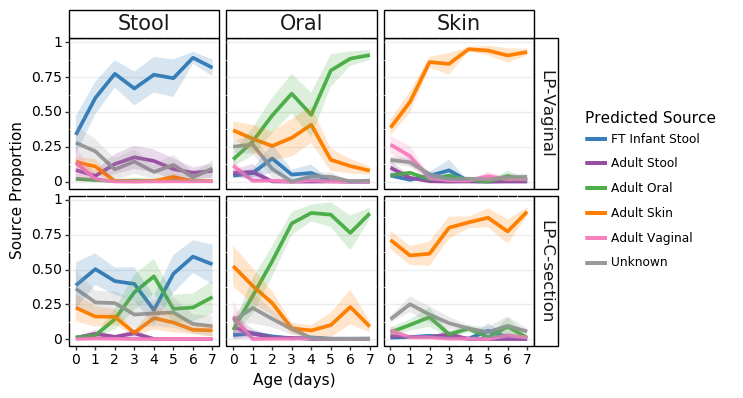

<ggplot: (-9223363272752178004)>

In [4]:
import plotnine as pn
pn.options.figure_size = (6,4)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('metadata_abx==0')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/Sourcetracker_NoAbx.svg", dpi=300)
p.save(root_dir + "results/figures/Sourcetracker_NoAbx.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/Sourcetracker_Abx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/Sourcetracker_Abx.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


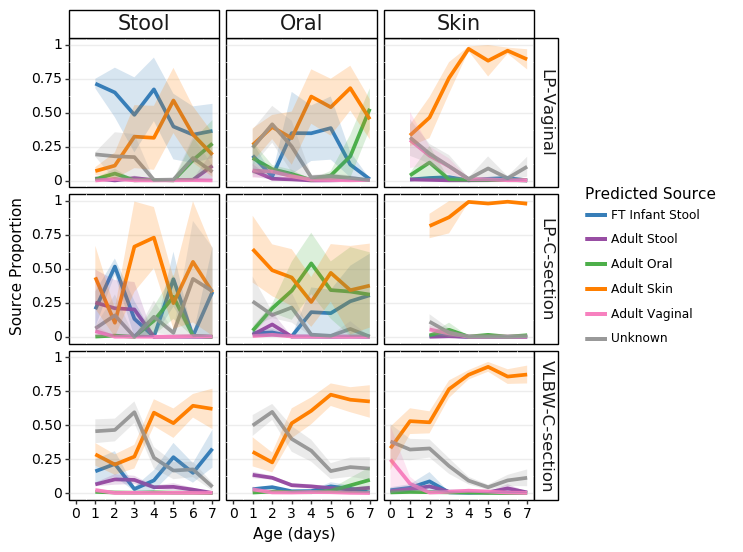

<ggplot: (8764093936027)>

In [5]:
import plotnine as pn
pn.options.figure_size = (6,6)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('metadata_abx==1')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/Sourcetracker_Abx.svg", dpi=300)
p.save(root_dir + "results/figures/Sourcetracker_Abx.pdf", dpi=300)
p

With maternal antibiotics

In [7]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)

st2_dat = pd.read_csv(root_dir + "intermediate_data/sourcetracker2_output_v2/mixing_proportions.txt", sep='\t').melt(id_vars="SampleID").set_index("SampleID")
st2_dat = st2_dat.merge(md.loc[:,["sample_type","abx012","qiita_study_id","study_delivery_mode","age"]], right_index=True, left_index=True)
plot_dat = st2_dat.groupby(["study_delivery_mode","sample_type","abx012","age","variable"]).agg({"value":["mean",sem,"count"]}).dropna()
plot_dat = plot_dat.reset_index()
plot_dat.columns = ["study_delivery_mode","sample_type","abx012","age","variable","avg","err","n"]
plot_dat["err_min"] = plot_dat.apply(axis=1, func=lambda row: row.avg - row.err )
plot_dat["err_max"] = plot_dat.apply(axis=1, func=lambda row: row.avg + row.err )

plot_dat = plot_dat.replace({"FT_infant_stool":"FT Infant Stool",
                  "adult_stool":"Adult Stool",
                  "adult_oral":"Adult Oral",
                  "adult_skin":"Adult Skin",
                  "vaginal":"Adult Vaginal"})
plot_dat["variable"] = pd.Categorical(plot_dat.variable, categories = ["FT Infant Stool","Adult Stool","Adult Oral",
                                                                    "Adult Skin","Adult Vaginal","Unknown"], ordered=True)

plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode,
                                                 ordered=True,
                                                categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type,
                                        ordered=True,
                                        categories=["Stool","Oral","Skin"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/sourcetracker_NoAbx_Mabx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/sourcetracker_NoAbx_Mabx.pdf
  warn('Filename: {}'.format(filename), Plotnin

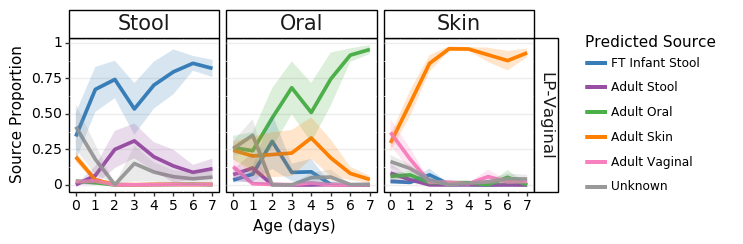

<ggplot: (8764094144597)>

In [8]:
import plotnine as pn
pn.options.figure_size = (6,2)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('abx012==0')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/sourcetracker_NoAbx_Mabx.svg", dpi=300)
p.save(root_dir + "results/figures/sourcetracker_NoAbx_Mabx.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/sourcetracker_Abx_Mabx.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/sourcetracker_Abx_Mabx.pdf
  warn('Filename: {}'.format(filename), PlotnineWar

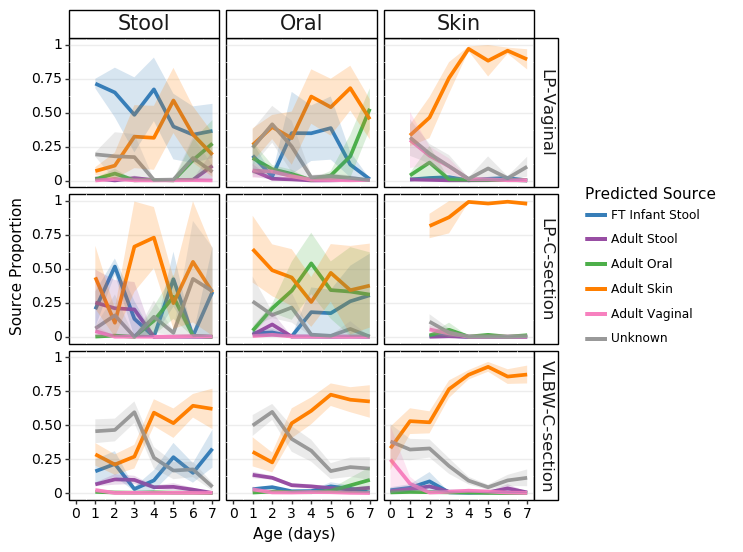

<ggplot: (-9223363272755719480)>

In [9]:
import plotnine as pn
pn.options.figure_size = (6,6)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('abx012==1')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/sourcetracker_Abx_Mabx.pdf", dpi=300)
p.save(root_dir + "results/figures/sourcetracker_Abx_Mabx.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/sourcetracker_MAbx_Mabx.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/sourcetracker_MAbx_Mabx.pdf
  warn('Filename: {}'.format(filename), PlotnineW

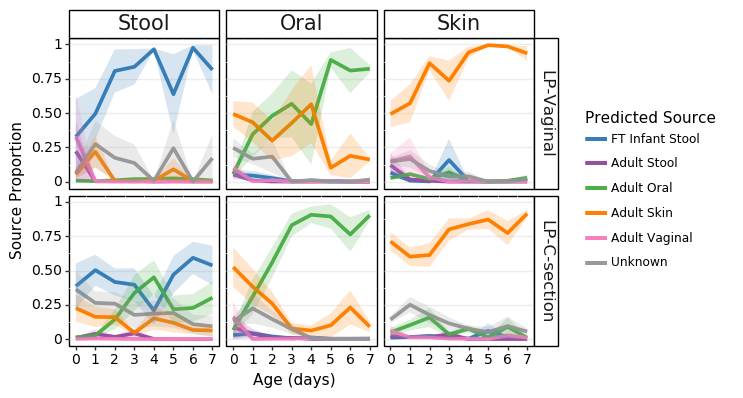

<ggplot: (8764093574001)>

In [10]:
import plotnine as pn
pn.options.figure_size = (6,4)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('abx012==2')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/sourcetracker_MAbx_Mabx.pdf", dpi=300)
p.save(root_dir + "results/figures/sourcetracker_MAbx_Mabx.pdf", dpi=300)
p

### With meeabolomicially informed antibiotics

In [12]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)

st2_dat = pd.read_csv(root_dir + "intermediate_data/sourcetracker2_output_v2/mixing_proportions.txt", sep='\t').melt(id_vars="SampleID").set_index("SampleID")
st2_dat = st2_dat.merge(md.loc[:,["sample_type","abx_any_source","qiita_study_id","study_delivery_mode","age"]], right_index=True, left_index=True)
plot_dat = st2_dat.groupby(["study_delivery_mode","sample_type","abx_any_source","age","variable"]).agg({"value":["mean",sem,"count"]}).dropna()
plot_dat = plot_dat.reset_index()
plot_dat.columns = ["study_delivery_mode","sample_type","abx_any_source","age","variable","avg","err","n"]
plot_dat["err_min"] = plot_dat.apply(axis=1, func=lambda row: row.avg - row.err )
plot_dat["err_max"] = plot_dat.apply(axis=1, func=lambda row: row.avg + row.err )

plot_dat = plot_dat.replace({"FT_infant_stool":"FT Infant Stool",
                  "adult_stool":"Adult Stool",
                  "adult_oral":"Adult Oral",
                  "adult_skin":"Adult Skin",
                  "vaginal":"Adult Vaginal"})
plot_dat["variable"] = pd.Categorical(plot_dat.variable, categories = ["FT Infant Stool","Adult Stool","Adult Oral",
                                                                    "Adult Skin","Adult Vaginal","Unknown"], ordered=True)

plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode,
                                                 ordered=True,
                                                categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type,
                                        ordered=True,
                                        categories=["Stool","Oral","Skin"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/Sourcetracker_metabolomics_abx_NoAbx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/Sourcetracker_metabolomics_abx_NoAbx.pdf
  warn('Filename: {}'.f

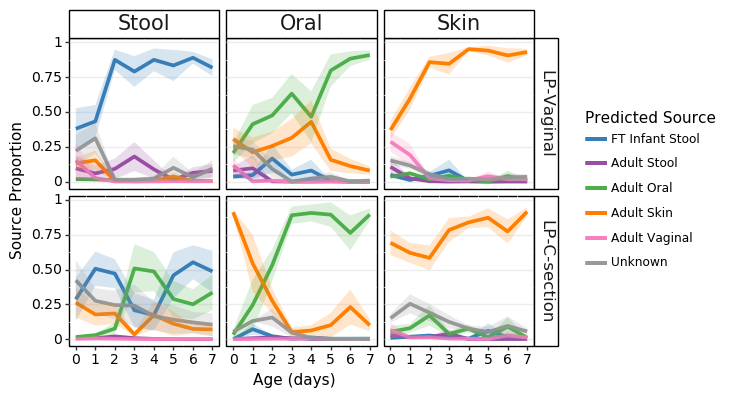

<ggplot: (-9223363272761803765)>

In [15]:
import plotnine as pn
pn.options.figure_size = (6,4)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('abx_any_source==0')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/Sourcetracker_metabolomics_abx_NoAbx.svg", dpi=300)
p.save(root_dir + "results/figures/Sourcetracker_metabolomics_abx_NoAbx.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/Sourcetracker_metabolomics_abx_Abx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/Sourcetracker_metabolomics_abx_Abx.pdf
  warn('Filename: {}'.forma

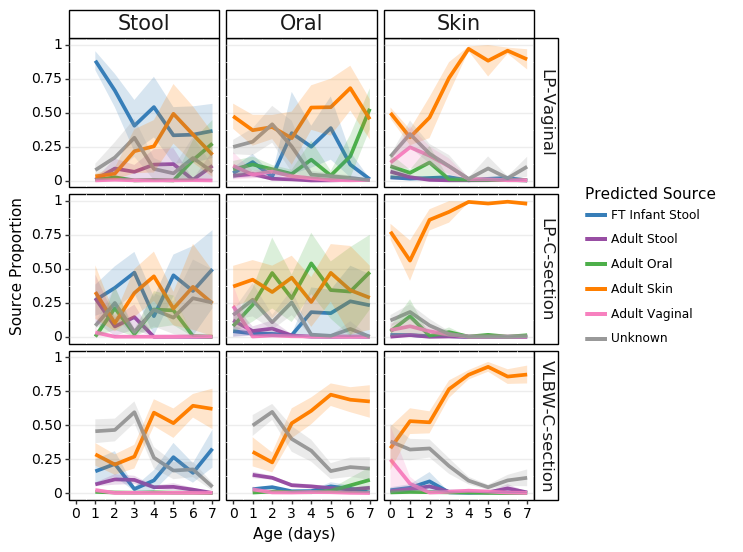

<ggplot: (8764093394254)>

In [16]:
import plotnine as pn
pn.options.figure_size = (6,6)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_dat.query('abx_any_source==1')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
        strip_background = pn.element_rect(fill="white",color="black")
     )
   )
p.save(root_dir + "results/figures/svg/Sourcetracker_metabolomics_abx_Abx.svg", dpi=300)
p.save(root_dir + "results/figures/Sourcetracker_metabolomics_abx_Abx.pdf", dpi=300)
p